In [15]:
# Import packages.
import cvxpy as cp
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

# Define some standard matrices
eye3 = np.array([[1],[1],[1]])

# Target landing site
q = np.array([0, 0, 0]) # In navigation frame [m]

# Environment
g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]

# Boundary Value
r_0 = np.array([2400, 450, -330]) # Initial Position m
dr_0 = np.array([-10, -40, 10])   # Initial Velocity m/s
m_0 = 2000 # initial mass [kg]
m_f = 300  # dry mass [kg]

# Mas Consumption Rate
alpha = 5e-4 # fuel consumption rate [s/m]

# Propulsion Values
T_max = 24000 # Max Thrust [N]
rho_1 = 0.2 * T_max # Lower Thrust Limit
rho_2 = 0.8 * T_max # Upper Thrust Limit
theta = 45 * np.pi / 180 # max thrust angle constraint [rad]

# Define the S matrix
S_w = np.array([[ 0, -w[2], w[1]],
                [ w[2], 0, -w[1]],
                [-w[1], w[0], 0]])

# Construct the A matrix
A_w_top = np.concatenate([np.zeros([3,3]), np.eye(3)], 1)
A_w_bot = np.concatenate( [-np.power(S_w,2), -2 * S_w], 1 )
A_w = np.concatenate( [A_w_top, A_w_bot], 0 )

# Construct the B matrix
B = np.concatenate([np.zeros([3,3]),np.eye(3)])

# Define the body axis variable which the thrust vector is constrained against
n_hat = np.array([1,0,0])

# Define and solve the CVXPY problem.
tf = 60  # final time [s]
nStep = 200 # number of timesteps
tstep = tf / nStep

# Glide Constraints
theta = 45 * np.pi / 180 # max thrust angle constraint [rad]
gamma_gs = 30 * np.pi / 180 # glide constraint [rad]

# Velocity Constraints
V_max = 100 # m/s

# Define the E matrix
e1 = np.array([1, 0, 0]) 
e2 = np.array([0, 1, 0]) 
e3 = np.array([0, 0, 1]) 
E = np.concatenate([[e2],[e3]], axis=0)

In [16]:
def initialize_variables(n):
  # Create a time vector from 0 to tf with n intervals
  ts, delt = np.linspace(0,tf,n,endpoint=True,retstep=True) 

  # Define the optimization variables
  x_t  = cp.Variable([6,n+1]) # State time history
  dx_t = cp.Variable([6,n]) # State Derivative time history
  T_c  = cp.Variable([3,n]) # Thrust Vector time history
  m_t  = cp.Variable([1,n+1]) # Mass time history
  dm_t = cp.Variable([1,n])   # Mass Flow time history

  # Define the slack variable
  Gamma_t = cp.Variable([1,n])   # Mass Flow time history


  sigma_t = cp.Variable([1,n]) # Slack Variable    sigma(t) = Gamma(t) / m(t)
  u_t = cp.Variable([3,n])     # Slack Variable    u(t)     = T(t) / m(t)
  z_t = cp.Variable([1,n+1])   # Slack Variable    z(t)     = ln(m(t))
  dz_t = cp.Variable([1,n])   # Slack Variable     dz(t)    = dm(t) / m(t)

  z_0 = np.log(m_0 - alpha * rho_2 * ts)
  dp = 0         

  return x_t, dx_t, sigma_t, u_t, z_t, dz_t, z_0, ts

In [17]:
def get_mle_obj_and_const(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n):
    
    # Define the environment
    g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
    w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]

    # Define the MLE objective function
    mle_obj  = cp.Minimize(cp.norm( x_t_dt[0:2+1,-1] - q )) # (25)

    # Define the Boundary Value Constraints
    bv_const = [x_t_dt[0:2+1,0] == r_0_dt,                     # (26)
                x_t_dt[3:5+1,0] == dr_0_dt,                    # (26)
                z_t_dt[0,0] == np.log(m_0_dt),                 # (26)
                x_t_dt[3:5+1,-1] == 0,                         # (27)
                z_t_dt >= np.log(m_f)]                         # (27)

    # Define the Vehicle Dynamics Constraints
    vd_const = [dx_t_dt == A_w * x_t_dt[:,0:n] + B * (np.matlib.repmat(g.T, n, 1).T + u_t ),         # (28) 
                dz_t_dt[0,:] == -alpha * sigma_t_dt[0,0:n]]    # (28)

    # Define the Propulsion Constraints
    p_const = [rho_1 * np.exp(-z_0_dt[0]) * ((1 - (z_t_dt[0,0:n] - z_0)) + cp.power((z_t_dt[0,0:n] - z_0_dt),2) / 2) <= sigma_t_dt[0,:], # (29)
              sigma_t_dt[0,:] <= rho_2 * np.exp(-z_0_dt[0]) * (1 - (z_t_dt[0,0:n] - z_0_dt)),                                            # (29)
              cp.norm(u_t, axis=0) <= sigma_t_dt[0,:],                      # (34)
              n_hat * u_t >= np.cos(theta) * sigma_t_dt[0,:]]               # (34)

    # Define the Lookahead Constraints
    la_const = [x_t_dt[:,1:n+1] == x_t_dt[:,0:n] + dx_t_dt * tstep,          # (28)
                z_t_dt[0,1:n+1] == z_t_dt[0,0:n] + dz_t_dt[0,:] * tstep]     # (28)

    # Collect the constraints
    mle_const = bv_const + vd_const + p_const + la_const

    return mle_obj, mle_const


In [18]:
# Initialize the index
n = nStep

# Initialize the convex optimization variables
x_t, dx_t, sigma_t, u_t, z_t, dz_t, z_0, ts = initialize_variables(nStep)

# Initialize the loggers
x_t_hist = np.zeros([nStep, 6, nStep])
z_t_hist = np.zeros([nStep, 1, nStep])
u_t_hist = np.zeros([nStep, 3, nStep])
t_hist   = np.zeros([nStep, 1, nStep])

# Recalculate the convex problem for each time step
# Note: Convex problem cannot be solved when the array size is less than 3
for t_idx in range(nStep-1):

  # Define the state estimation noise
  pos_noise = np.random.randn(3) * 0.1  * 0  # m
  vel_noise = np.random.randn(3) * 0.01 * 0. # m/s

  # 
  x_t_dt  = x_t
  dx_t_dt = dx_t
  z_t_dt  = z_t
  dz_t_dt = dz_t
  u_t_dt = u_t
  sigma_t_dt = sigma_t
  z_0_dt = z_0

  if (t_idx == 0):
    r_0_dt = r_0
    dr_0_dt = dr_0
    m_0_dt = m_0
  else:
    r_0_dt = x_t_dt[0:2+1,0].value + pos_noise.T
    dr_0_dt = x_t_dt[3:5+1,0].value + vel_noise.T
    m_0_dt = np.exp(z_t[0,0].value)

  # Define the constraints and define the problem
  mle_obj, mle_const = get_mle_obj_and_const(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n)
  mle_prob = cp.Problem(mle_obj, mle_const)

  # Solve the convex problem
  mle_prob.solve()  # Returns the optimal value.

  # Log the solution at each step
  x_t_hist[t_idx,:,0:n] = x_t.value[:,0:n]
  z_t_hist[t_idx,:,0:n] = z_t.value[:,0:n]
  u_t_hist[t_idx,:,0:n] = u_t.value[:,0:n]
  t_hist[t_idx,:,0:n]   = ts[nStep-n:nStep]

  # Update Step and add noise
  x_t = x_t_dt[:,1:]
  dx_t = dx_t_dt[:,1:]
  z_t = z_t_dt[:,1:]
  dz_t = dz_t_dt[:,1:]
  u_t = u_t_dt[:,1:]
  sigma_t = sigma_t_dt[:,1:]
  z_0 = z_0_dt[1:]

  n = n - 1


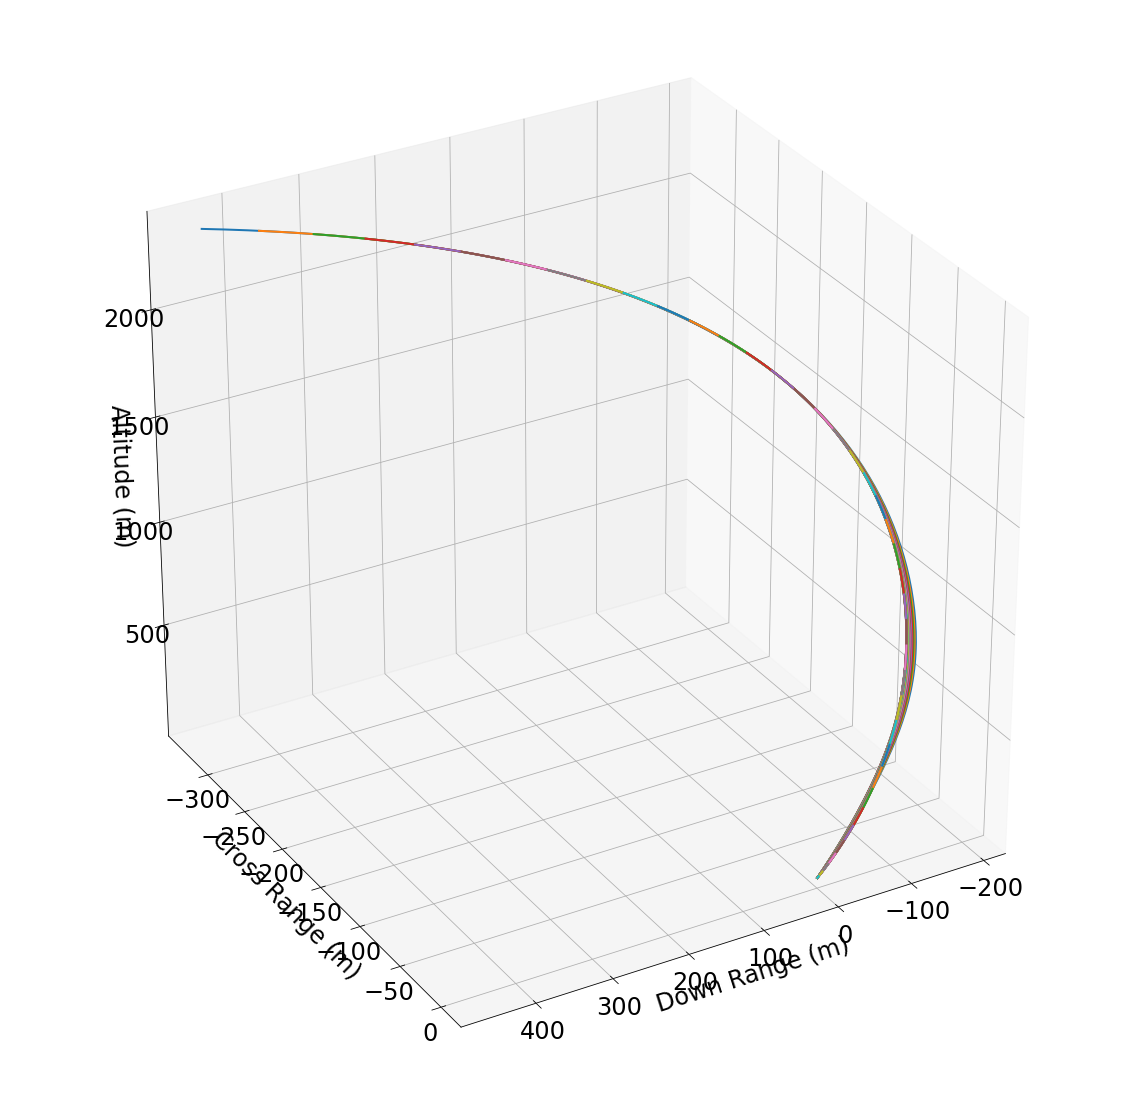

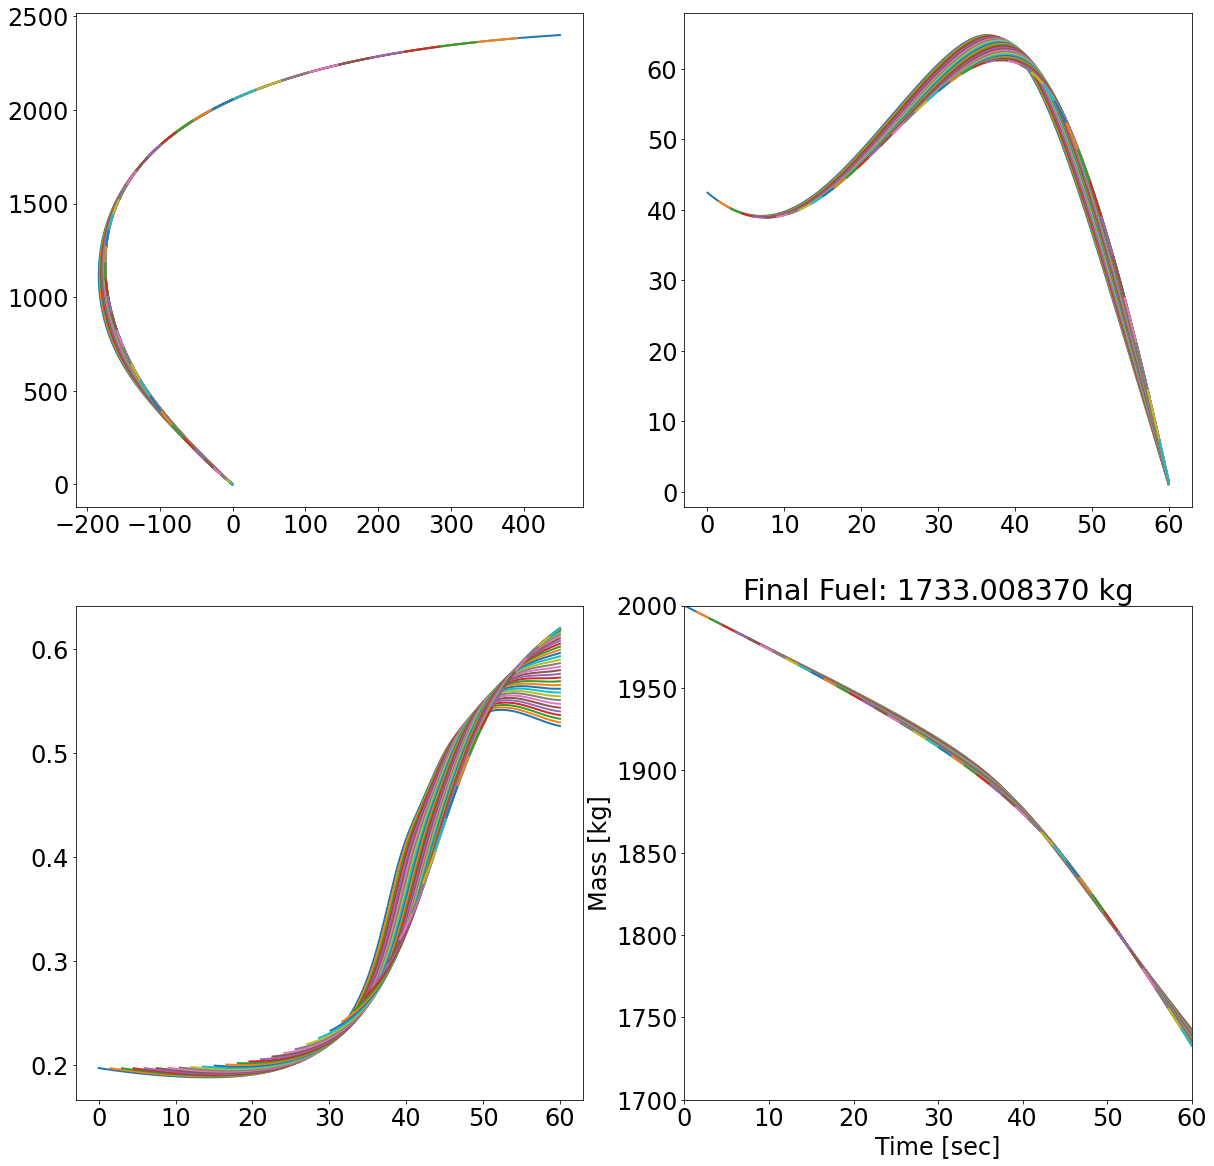

In [20]:
# Print result.
# print("\nThe optimal value is", min_land_err_prob.value)
# print("Solution to the X State is")

fig1 = plt.figure()
ax = plt.axes(projection='3d')
i_ary = range(0, nStep-1, 5)

for i in i_ary:
  x_t_sln = x_t_hist[i,:,:nStep-i]
  z_t_sln = z_t_hist[i,:,:nStep-i]
  u_t_sln = u_t_hist[i,:,:nStep-i]

  m_t = np.exp(z_t_sln)
  T_t = np.multiply(u_t_sln, m_t)

  ax.plot3D(x_t_sln[1,:],  x_t_sln[2,:], x_t_sln[0,:], linewidth=2)
  ax.set_xlabel('Down Range (m)')
  ax.set_ylabel('Cross Range (m)')
  ax.set_zlabel('Altitude (m)')

ax.view_init(30, 60)

fig2 = plt.figure()
s1 = plt.subplot(2,2,1)
s2 = plt.subplot(2,2,2)
s3 = plt.subplot(2,2,3)
s4 = plt.subplot(2,2,4)

for i in i_ary:
  x_t_sln = x_t_hist[i,:,:nStep-i]
  z_t_sln = z_t_hist[i,:,:nStep-i]
  u_t_sln = u_t_hist[i,:,:nStep-i]
  t_sln   = t_hist[i,:,:nStep-i]

  m_t = np.exp(z_t_sln)
  T_t = np.multiply(u_t_sln, m_t)

  s1.plot(x_t_sln[1,:], x_t_sln[0,:], linewidth=2)
  plt.ylabel('X Axis (Altitude) [m]')
  plt.xlabel('Y Axis')
  plt.xlim([-200, 450])
  plt.ylim([0, 2500])
  plt.title('Landing Error: %f m' % (np.linalg.norm(q - x_t_sln[0:2+1,-1])))

  s2.plot(t_sln[0,:], np.linalg.norm(x_t_sln[3:5+1,:], axis=0), linewidth=2)
  plt.ylabel('Velocity Magnitude [m/s]')
  plt.xlabel('Time [sec]')
  plt.xlim([0, 60])
  plt.ylim([0, 80])
  plt.title('Max Velocity: %f m/s' % (np.max(np.linalg.norm(x_t_sln[3:5+1,:], axis=0))))

  s3.plot(t_sln[0,:], np.linalg.norm(T_t, axis=0) / T_max, linewidth=2)
  plt.ylabel('Max Thrust Percentage [%]')
  plt.xlabel('Time [sec]')
  plt.xlim([0, 60])
  plt.ylim([0, 1])
  plt.title('Max Thrust Percent: %f' % (np.max(np.linalg.norm(T_t, axis=0) / T_max)))

  s4.plot(t_sln[0,:], m_t[0,:], linewidth=2)
  plt.ylabel('Mass [kg]')
  plt.xlabel('Time [sec]')
  plt.xlim([0, 60])
  plt.ylim([1700, 2000])
  plt.title('Final Fuel: %f kg' % (m_t[0,-1]))

plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 24})

In [21]:
# Define the Convex Relaxed Minimum Fuel Problem 

# Take the final optimal position from the Minimium Landing Error Problem
dp = x_t[0:2+1,-1].value # Only extract the y and z components since x is altitude

In [22]:
def get_mf_obj_and_const(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, dp, n):
    
    # Define the environment
    g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
    w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]

    # Define the MF objective function
    mf_obj  = cp.Minimize(cp.sum(sigma_t_dt))         # (31)

    # Define the Boundary Value Constraints
    bv_const = [x_t_dt[0:2+1,0] == r_0_dt,                     # (26)
                x_t_dt[3:5+1,0] == dr_0_dt,                    # (26)
                z_t_dt[0,0] == np.log(m_0_dt),                 # (26)
                x_t_dt[3:5+1,-1] == 0,                         # (27)
                z_t_dt >= np.log(m_f)]                         # (27)

    # Define the Vehicle Dynamics Constraints
    vd_const = [dx_t_dt == A_w * x_t_dt[:,0:n] + B * (np.matlib.repmat(g.T, n, 1).T + u_t ),         # (28) 
                dz_t_dt[0,:] == -alpha * sigma_t_dt[0,0:n]]    # (28)

    # Define the Propulsion Constraints
    p_const = [rho_1 * np.exp(-z_0_dt[0]) * ((1 - (z_t_dt[0,0:n] - z_0)) + cp.power((z_t_dt[0,0:n] - z_0_dt),2) / 2) <= sigma_t_dt[0,:], # (29)
              sigma_t_dt[0,:] <= rho_2 * np.exp(-z_0_dt[0]) * (1 - (z_t_dt[0,0:n] - z_0_dt)),                                            # (29)
              cp.norm(u_t, axis=0) <= sigma_t_dt[0,:],                      # (34)
              n_hat * u_t >= np.cos(theta) * sigma_t_dt[0,:]]               # (34)

    # Define the Lookahead Constraints
    la_const = [x_t_dt[:,1:n+1] == x_t_dt[:,0:n] + dx_t_dt * tstep,          # (28)
                z_t_dt[0,1:n+1] == z_t_dt[0,0:n] + dz_t_dt[0,:] * tstep]     # (28)

    # Define the Landing Error Constraints
    le_const = [cp.norm( x_t_dt[0:2+1,-1] - q ) <= cp.norm(dp - q)] 

    # Collect the constraints
    mf_const = bv_const + vd_const + p_const + la_const + le_const

    return mf_obj, mf_const


In [23]:
# Initialize the index
n = nStep

# Initialize the convex optimization variables
x_t, dx_t, sigma_t, u_t, z_t, dz_t, z_0, ts = initialize_variables(nStep)

# Initialize the loggers
x_t_hist = np.zeros([nStep, 6, nStep])
z_t_hist = np.zeros([nStep, 1, nStep])
u_t_hist = np.zeros([nStep, 3, nStep])
t_hist   = np.zeros([nStep, 1, nStep])

# Recalculate the convex problem for each time step
# Note: Convex problem cannot be solved when the array size is less than 3
for t_idx in range(nStep-1):

  # Define the state estimation noise
  pos_noise = np.random.randn(3) * 0.1  * 0  # m
  vel_noise = np.random.randn(3) * 0.01 * 0. # m/s

  # 
  x_t_dt  = x_t
  dx_t_dt = dx_t
  z_t_dt  = z_t
  dz_t_dt = dz_t
  u_t_dt = u_t
  sigma_t_dt = sigma_t
  z_0_dt = z_0

  if (t_idx == 0):
    r_0_dt = r_0
    dr_0_dt = dr_0
    m_0_dt = m_0
  else:
    r_0_dt = x_t_dt[0:2+1,0].value + pos_noise.T
    dr_0_dt = x_t_dt[3:5+1,0].value + vel_noise.T
    m_0_dt = np.exp(z_t[0,0].value)

  # Define the constraints and define the problem
  mf_obj, mf_const = get_mf_obj_and_const(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, dp, n)
  mf_prob = cp.Problem(mf_obj, mf_const)

  # Solve the convex problem
  mf_prob.solve()  # Returns the optimal value.

  # Log the solution at each step
  x_t_hist[t_idx,:,0:n] = x_t.value[:,0:n]
  z_t_hist[t_idx,:,0:n] = z_t.value[:,0:n]
  u_t_hist[t_idx,:,0:n] = u_t.value[:,0:n]
  t_hist[t_idx,:,0:n]   = ts[nStep-n:nStep]

  # Update Step and add noise
  x_t = x_t_dt[:,1:]
  dx_t = dx_t_dt[:,1:]
  z_t = z_t_dt[:,1:]
  dz_t = dz_t_dt[:,1:]
  u_t = u_t_dt[:,1:]
  sigma_t = sigma_t_dt[:,1:]
  z_0 = z_0_dt[1:]

  n = n - 1

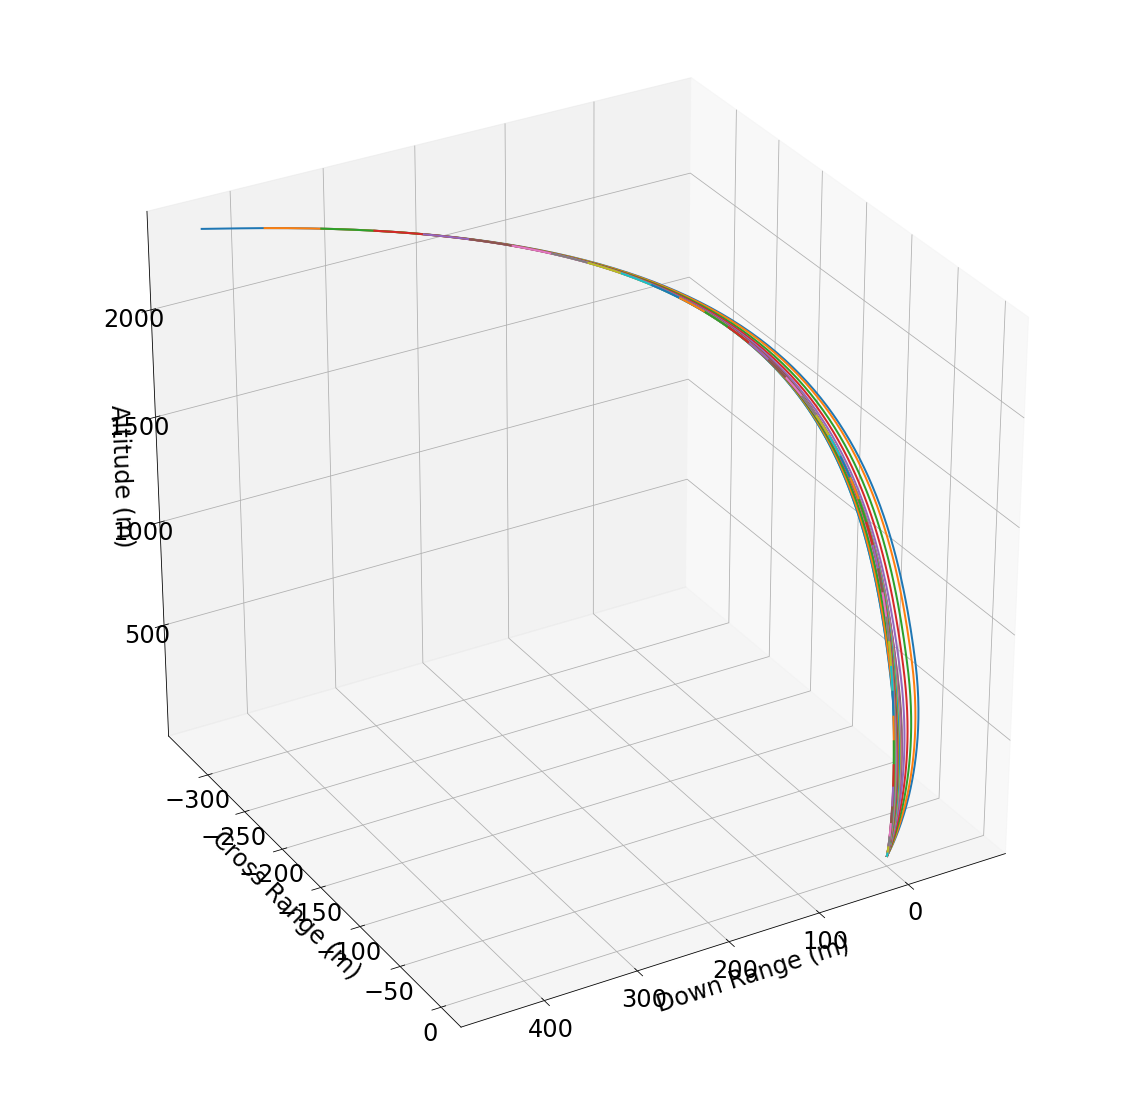

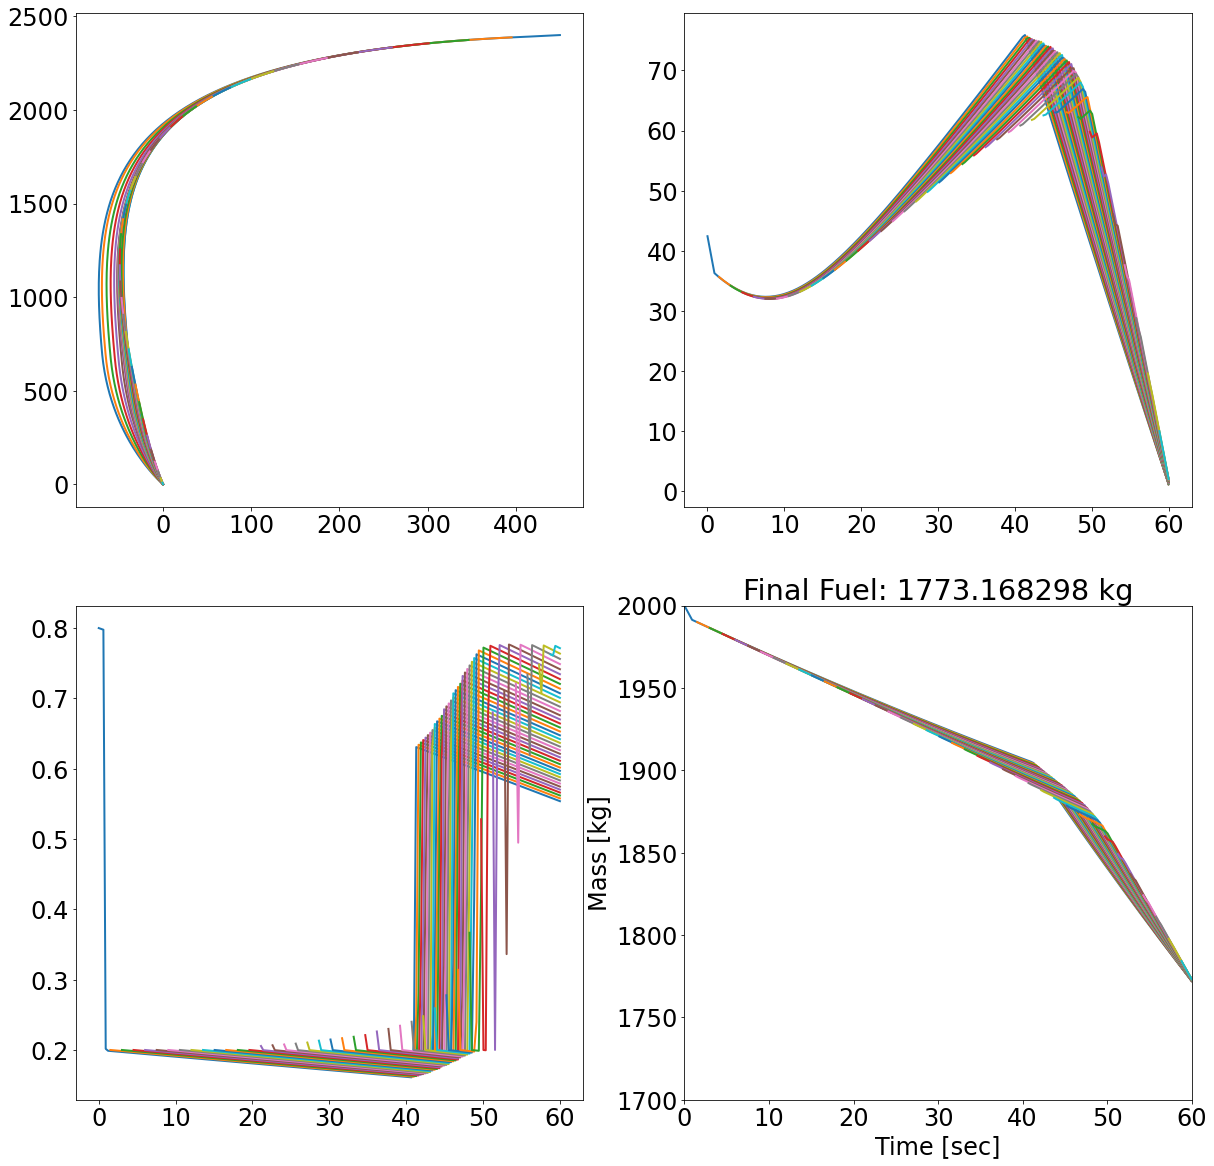

In [24]:
# Print result.
# print("\nThe optimal value is", min_land_err_prob.value)
# print("Solution to the X State is")

fig1 = plt.figure()
ax = plt.axes(projection='3d')
i_ary = range(0, nStep-1, 5)

for i in i_ary:
  x_t_sln = x_t_hist[i,:,:nStep-i]
  z_t_sln = z_t_hist[i,:,:nStep-i]
  u_t_sln = u_t_hist[i,:,:nStep-i]

  m_t = np.exp(z_t_sln)
  T_t = np.multiply(u_t_sln, m_t)

  ax.plot3D(x_t_sln[1,:],  x_t_sln[2,:], x_t_sln[0,:], linewidth=2)
  ax.set_xlabel('Down Range (m)')
  ax.set_ylabel('Cross Range (m)')
  ax.set_zlabel('Altitude (m)')

ax.view_init(30, 60)

fig2 = plt.figure()
s1 = plt.subplot(2,2,1)
s2 = plt.subplot(2,2,2)
s3 = plt.subplot(2,2,3)
s4 = plt.subplot(2,2,4)

for i in i_ary:
  x_t_sln = x_t_hist[i,:,:nStep-i]
  z_t_sln = z_t_hist[i,:,:nStep-i]
  u_t_sln = u_t_hist[i,:,:nStep-i]
  t_sln   = t_hist[i,:,:nStep-i]

  m_t = np.exp(z_t_sln)
  T_t = np.multiply(u_t_sln, m_t)

  s1.plot(x_t_sln[1,:], x_t_sln[0,:], linewidth=2)
  plt.ylabel('X Axis (Altitude) [m]')
  plt.xlabel('Y Axis')
  plt.xlim([-200, 450])
  plt.ylim([0, 2500])
  plt.title('Landing Error: %f m' % (np.linalg.norm(q - x_t_sln[0:2+1,-1])))

  s2.plot(t_sln[0,:], np.linalg.norm(x_t_sln[3:5+1,:], axis=0), linewidth=2)
  plt.ylabel('Velocity Magnitude [m/s]')
  plt.xlabel('Time [sec]')
  plt.xlim([0, 60])
  plt.ylim([0, 80])
  plt.title('Max Velocity: %f m/s' % (np.max(np.linalg.norm(x_t_sln[3:5+1,:], axis=0))))

  s3.plot(t_sln[0,:], np.linalg.norm(T_t, axis=0) / T_max, linewidth=2)
  plt.ylabel('Max Thrust Percentage [%]')
  plt.xlabel('Time [sec]')
  plt.xlim([0, 60])
  plt.ylim([0, 1])
  plt.title('Max Thrust Percent: %f' % (np.max(np.linalg.norm(T_t, axis=0) / T_max)))

  s4.plot(t_sln[0,:], m_t[0,:], linewidth=2)
  plt.ylabel('Mass [kg]')
  plt.xlabel('Time [sec]')
  plt.xlim([0, 60])
  plt.ylim([1700, 2000])
  plt.title('Final Fuel: %f kg' % (m_t[0,-1]))

plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 24})